In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using Plots
using FITSIO

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423


In [5]:
datas = [Data("DESgc", "DESgc", 2 , 2),
         Data("DESgc", "DESwl", 2 , 3)];
Nzs = [Nz(1), Nz(2), Nz(3), Nz(4), Nz(5)]
Cls_metas = Cls_meta(datas);
cov_tot = Cls_metas.cov_tot;
data_vector = Cls_metas.data_vector;

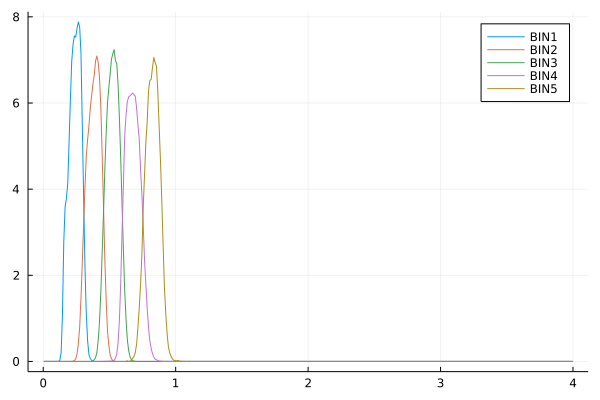

In [6]:
plot(Nzs[1].zs, Nzs[1].nz, label="BIN1")
plot!(Nzs[2].zs, Nzs[2].nz, label="BIN2")
plot!(Nzs[3].zs, Nzs[3].nz, label="BIN3")
plot!(Nzs[4].zs, Nzs[4].nz, label="BIN4")
plot!(Nzs[5].zs, Nzs[5].nz, label="BIN5")


In [4]:
cosmology_test = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")

Cosmology(CosmoPar{Real}(0.3, 0.05, 0.67, 0.96, 0.81, 1.0092592592592593, 9.312755027430078e-5, 0.6999068724497256), [0.00010000000000000009, 0.00010556729942333301, 0.00011144454707535637, 0.00011764899870201866, 0.0001241988707283131, 0.00013111339374215648, 0.00013841286895587576, 0.00014611872781107477, 0.00015425359490188242, 0.0001628413544013252  …  61.40946221409371, 64.82831084981079, 68.43749702590878, 72.24761740317568, 76.26985859023445, 80.51602998770541, 84.99859846090156, 89.7307249428564, 94.72630307515249, 100.00000000000004], [2406.237882850354, 2534.573724610856, 2669.7393327076898, 2812.0956417826924, 2962.022237564655, 3119.918250632867, 3286.2032814672125, 3461.318355899214, 3645.726909654808, 3839.915800182919  …  0.0017811081989842837, 0.0015344413789781795, 0.0013217757140307164, 0.001138448788397389, 0.0009804337997963348, 0.0008442534762913425, 0.0007269055648214446, 0.0006257983493148575, 0.000538694859344118, 0.00046366460782812006], 0.054178472776330366, [

In [5]:
theory_test = Theory(cosmology_test, Cls_metas, Nzs)

Theory(Any[NumberCountsTracer(400-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), 0) with element type Float64:
 7.54849147931214e-7
 2.5941589813645726e-6
 4.5984890921492065e-6
 7.108028903950896e-6
 9.526112483298392e-6
 1.3487498937675878e-5
 1.7348808581820102e-5
 2.282368040106995e-5
 2.89045658355712e-5
 3.5961076318589954e-5
 4.474518675177204e-5
 5.493205579411745e-5
 6.383362063242772e-5
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0, 2.0, 0), WeakLensingTracer(400-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), 0) with element type Float64:
 1.0030180987739053e-9
 9.964245467830256e-7
 1.9695145236263417e-6
 2.9185930083732217e-6
 3.844932632537704e-6
 4.746717589110546e-6
 5.6233330415880364e-6
 6.474870300480444e-6
 7.3007414838205344e-6
 8.09975545325876e-6
 8.874756345468103e-6
 9.620729099242038e-6
 1.0339784236248797e-5
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0

In [7]:
@model function model(data_vector)
    Ωm ~ Uniform(0.2, 0.3)
    h ~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.7, 1.0)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    theory = Theory(cosmology, Cls_metas, Nzs).Cls
    data_vector ~ MvNormal(theory, cov_tot)
end;

iterations = 50
step_size = 0.005
samples_per_step = 10
cores = 4

# Start sampling.
folname = string("DES_gc2gc2_gc2wl3_", "stpsz_", step_size, "_smpls_", samples_per_step)
if isdir(folname)
    println("Folder already exists")
    if isfile(joinpath(folname, "chain.jls"))
        println("Restarting from past chain")
        past_chain = read(joinpath(folname, "chain.jls"), Chains)
        new_chain = sample(model(data_vector), HMC(step_size, samples_per_step), iterations,
                           progress=true; save_state=true, resume_from=past_chain)
    end
else
    mkdir(folname)
    println("Created new folder")
    new_chain = sample(model(data_vector), HMC(step_size, samples_per_step),
                iterations, progress=true; save_state=true)
end

info = describe(new_chain)[1]
fname_info = string("info.csv")
CSV.write(joinpath(folname, fname_info), info)


fname_jls = string("chain.jls")
write(joinpath(folname, fname_jls), new_chain)
    
fname_csv = string("chain.csv")
CSV.write(joinpath(folname, fname_csv), new_chain)



Sampling: 100%|█████████████████████████████████████████| Time: 0:05:34


Created new folder


"DES_gc2gc2_gc2wl3_stpsz_0.005_smpls_10/chain.csv"

In [ ]:
@model function model(data_vector)
    Ωm ~ Uniform(0.2, 0.3)
    h ~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.7, 1.0)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    theory = Theory(cosmology, Cls_metas, Nzs).Cls
    data_vector ~ MvNormal(theory, cov_tot)
end;

iterations = 500

# Start sampling.
folname = string("DES_gs_MH")
if isdir(folname)
    println("Folder already exists")
    if isfile(joinpath(folname, "chain.jls"))
        println("Restarting from past chain")
        past_chain = read(joinpath(folname, "chain.jls"), Chains)
        new_chain = sample(model(data_vector), MH(), iterations,
                           progress=true; save_state=true, resume_from=past_chain)
    end
else
    mkdir(folname)
    println("Created new folder")
    new_chain = sample(model(data_vector), MH(), iterations,
                       progress=true; save_state=true)
end

info = describe(new_chain)[1]
fname_info = string("info.csv")
CSV.write(joinpath(folname, fname_info), info)


fname_jls = string("chain.jls")
write(joinpath(folname, fname_jls), new_chain)
    
fname_csv = string("chain.csv")
CSV.write(joinpath(folname, fname_csv), new_chain)



Sampling:  10%|████▏                                    |  ETA: 0:04:30